# Word2Vec for Text Classification

In this short notebook, we will see an example of how to use a pre-trained Word2vec model for doing feature extraction and performing text classification.

We will use the sentiment labelled sentences dataset from UCI repository
http://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences

The dataset consists of 1500 positive, and 1500 negative sentiment sentences from Amazon, Yelp, IMDB. Let us first combine all the three separate data files into one using the following unix command:

```cat amazon_cells_labelled.txt imdb_labelled.txt yelp_labelled.txt > sentiment_sentences.txt```

For a pre-trained embedding model, we will use the Google News vectors.

In [2]:
pip install wget

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9680 sha256=6a60f1cbcf4657085226b8dce7221ddf2cf09e26a76bbfd6a64e332f491a1ab6
  Stored in directory: c:\users\natha\appdata\local\pip\cache\wheels\ba\78\fb\e0c24a9e73d7483b073d15b7e05f43f3fc2ac75eff6899c7aa
Successfully built wget
Note: you may need to restart the kernel to use updated packages.


In [113]:
#basic imports
import warnings
warnings.filterwarnings('ignore')
import os
import wget
import gzip
import shutil
from time import time
import pandas as pd

#pre-processing imports
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from string import punctuation

#imports related to modeling
import numpy as np
import gensim.downloader
from gensim.models import Word2Vec, KeyedVectors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Natha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Natha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Loading the dataset

In [6]:
!type amazon_cells_labelled.txt imdb_labelled.txt yelp_labelled.txt > sentiment_sentences.txt


amazon_cells_labelled.txt



imdb_labelled.txt



yelp_labelled.txt




In [169]:
#Read text data, categories.
#the file path consists of tab separated sentences and categories.
texts = []
categories = []
fh = open('./Data/sentiment_sentences.txt')
for line in fh:
    text, sentiment = line.split("\t")
    texts.append(text)
    categories.append(sentiment)

In [170]:
#Inspect the dataset
print(len(categories), len(texts))
print("the category of text 1: '",texts[1], "' is ", categories[1])
print("The set of categories are: ", set(categories))

3000 3000
the category of text 1: ' Good case, Excellent value. ' is  1

The set of categories are:  {'0\n', '1\n'}


## Loading the word2vec model
For that task use KeyedVectors imported from the gensim library. <br>
* Load the pre-trained google news 300 word2vec model to the variable w2v_model
* Inspect the model by checking the words inside w2v_model: the number of words

**NB:**<br>
The magic command *%time* used returns the computational cost of the operation following it.

In [34]:
import gensim
from gensim.models import KeyedVectors
import gensim.downloader as api

In [36]:
#Load W2V model. This will take some time.
%time w2v_model = api.load("word2vec-google-news-300")  # download the model and return as object ready for us
print('done loading Word2Vec')

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Wall time: 11min 46s
done loading Word2Vec


In [171]:
#Inspect the model
word2vec_vocab = w2v_model.key_to_index.keys() # Create a list of all the words in the Word2Vec model's vocabulary
word2vec_vocab_lower = [item.lower() for item in word2vec_vocab]
print(len(set(word2vec_vocab)), len(set(word2vec_vocab_lower)))

3000000 2702150


The Word2Vec model has a vocabulary of 3 million words. The second line converts all the words in the vocabulary to lowercase and creates a new list. The length of the original vocabulary is 3 million, while the length of the new list with lowercase words is 2.7 million. This suggests that there were around 300,000 words in the original vocabulary that had uppercase letters.

## Preprocessing text
* Remove the stopwords
* Remove punctuations
* Remove digits
* Convert all text to lower case
* Tokenize the text

In [172]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [173]:
print(stopwords)

{'you', 'itself', 'being', 'over', "couldn't", 'doing', 'have', 'below', 'for', 'at', 'isn', 'between', 'was', 'mustn', 've', 'more', 'this', 'has', 'and', 'weren', 'hasn', 'ours', 'does', 'with', 'wasn', 'own', 'now', 'who', 'are', 'down', 'to', 'my', 'o', 'by', 'why', 'that', "hasn't", "don't", 'while', 'nor', 'before', 'out', 'will', 'do', 'just', 'again', 'each', 'some', "needn't", 'be', 'other', "wouldn't", 'himself', 'haven', 'few', 'shan', 'where', 'them', 'did', 'an', 'ourselves', "shan't", 'i', "you're", "you'll", 'further', 't', "isn't", 'couldn', 'of', 'into', 'yourselves', 'only', 'theirs', "won't", 'but', 'its', 'not', 'against', 'she', 'their', 'won', 'it', "aren't", 'him', 'too', "shouldn't", "weren't", 'herself', 'yourself', "you've", "mightn't", 'a', 'wouldn', 'ain', "it's", "haven't", 'll', "doesn't", 'here', 'they', 'through', 'needn', 'both', 're', 'our', "should've", 'yours', 'your', 'didn', 'aren', 'or', 'those', 'can', 'from', 'then', 'what', 'any', 'there', 'mig

In [174]:
#preprocess the text.
def preprocess_corpus(texts):
    """
    This function preprocesses a list of text strings by converting them to lowercase,
    removing punctuation, digits, and stop words, and returning a list of clean text strings.
    
    Parameters:
    -----------
    texts: list
        The list of text strings to preprocess.
        
    Returns:
    --------
    docs_processed: list
        The list of preprocessed text strings.
    """    
    tokens_processed = []
    for doc in texts:
        # Convert all text to lowercase
        doc = doc.lower()
        # Remove punctuations n digits
        doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
        # Tokenize the text & Remove stopwords
        tokens = [token for token in doc.split() if token not in stopwords]
        tokens_processed.append(tokens)
    return tokens_processed


In [175]:
texts_processed = preprocess_corpus(texts) # Preprocess the texts

# Print the number of categories and preprocessed texts to make sure they match
print(len(categories), len(texts_processed))

# Print an example preprocessed text and its corresponding category
print(texts_processed[1])
print(categories[1])

3000 3000
['good', 'case', 'excellent', 'value']
1



The first print statement prints the number of categories and preprocessed texts to make sure they match. Since there are 3000 texts in both categories and texts_processed, the numbers match.

The second print statement prints an example preprocessed text (texts_processed[1]) and its corresponding category (categories[1]). In this case, the preprocessed text is "good case excellent value" and its category is 1.

We can see that the preprocess function actually remove the capital letter and the punctuation from : "Good case, Excellent value." Also we can see that the sentence is well tokenize ans store in a list.

In [176]:
print(texts_processed[6])
print(categories[6])

['several', 'dozen', 'several', 'hundred', 'contacts', 'imagine', 'fun', 'sending', 'one', 'one']
0



Here we take the sentence : "If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one". We can see that the process function actually remove the stopwords. EVerything is working :)

## Converting text to numeric
In this section, we will convet the text to numerical data to be fed into a Machine Learning model for classification. <br>
We will extract the embeddings of words using w2v_model. <br>
Finally, every sentence is the average of the embeddings of its constituting words. 

In [177]:
# Creating a feature vector by averaging all embeddings for all sentences
def embedding_feats(list_of_lists, w2v_model):
    DIMENSION = 300  # dimensions of the word embeddings in the model
    zero_vector = np.zeros(DIMENSION)  # a vector of zeros to use as a placeholder for out-of-vocabulary words
    features = []  # a list to store the embedding features for each sentence
    
    # loop over each sentence in the list of lists
    for tokens in list_of_lists:
        feature_vec = np.zeros(DIMENSION)  # initialize an empty vector for this sentence's feature representation
        
        # loop over each word in the sentence
        for word in tokens:
            try:
                # get the word's embedding from the model and add it to the sentence's feature vector
                feature_vec = np.add(feature_vec, w2v_model[word])
            except KeyError:
                # if the word is not in the model's vocabulary, use the zero vector instead
                feature_vec = np.add(feature_vec, zero_vector)
        
        # divide the sentence's feature vector by the number of words to get the average
        feature_vec = np.divide(feature_vec, len(tokens))
        features.append(feature_vec)  # add the feature vector for this sentence to the list
    
    return features

# Example usage:
# embedded_texts = embedding_feats(texts_processed, w2v_model)
# print(len(embedded_texts))


This function takes a list of lists of preprocessed text (tokenized and cleaned) and a word2vec model and returns a list of feature vectors, where each feature vector is the average of the word embeddings for each word in the corresponding sentence.

The function first initializes a zero vector and an empty list to store the feature vectors. Then it loops over each sentence in the list of lists and initializes an empty vector for that sentence. It then loops over each word in the sentence and tries to get the word's embedding from the word2vec model. If the word is not in the model's vocabulary, it uses the zero vector instead. The function then divides the feature vector by the number of words in the sentence to get the average and adds the resulting feature vector to the list.

Finally, the function returns the list of feature vectors.

In [178]:
embedded_texts = embedding_feats(texts_processed, w2v_model)

In [201]:
type(embedded_texts)

list

In [179]:
print(texts_processed[1])
print(embedded_texts[1])

['good', 'case', 'excellent', 'value']
[-8.72802734e-03  3.85360718e-02 -3.76892090e-02  3.76281738e-02
  2.88085938e-02  1.33071899e-01  1.04202271e-01  1.25122070e-02
  8.15429688e-02  1.96411133e-01 -1.15005493e-01 -1.07528687e-01
  6.85424805e-02  1.03210449e-01 -1.34033203e-01  1.64794922e-01
  1.15722656e-01  9.20944214e-02 -5.98144531e-02 -1.00784302e-01
  2.13623047e-02 -3.56445312e-02 -5.05371094e-02  9.44824219e-02
  1.37603760e-01  4.16831970e-02 -1.05106354e-01  7.23266602e-02
 -6.80541992e-03  4.42962646e-02 -1.29089355e-02 -1.16348267e-01
  1.21215820e-01 -4.88281250e-04  1.49688721e-01  1.67114258e-01
  4.11987305e-02 -1.76849365e-02 -4.12597656e-02 -3.65600586e-02
  1.57836914e-01 -3.13892365e-02  5.98526001e-02  2.53143311e-02
 -1.13525391e-01 -1.01074219e-01  1.03820801e-01  2.39868164e-02
  4.63256836e-02 -4.69970703e-02  5.49316406e-02  5.71289062e-02
 -9.80224609e-02 -3.83300781e-02  3.49044800e-03  2.89916992e-02
 -5.82714081e-02 -6.11381531e-02  1.55151367e-01 -7

The output of the function embedding_feats() is embedded_texts, a list of embedding vectors, one for each input text.

## Text Classification
For this example, we will use a simple Logistic Regression to classify the text.<br>
* Initialize a Logistic Regression model
* Split the embedded_texts and categories to train and test data and target
* Fit the model with the training data samples
* Predict on the test data samples
* Print the classification report

In [180]:
#Take any classifier (LogisticRegression here, and train/test it like before.
model = LogisticRegression()

## Split the embedded_texts and categories to train and test data and target

In [181]:
# X = the column text contains textual data to extract features from
#X = data
X = embedded_texts
# y = target = the column we are learning to predict. 
#y = label
y = categories

print(len(X), len(y))

3000 3000


In [182]:
# split X and y into training and testing sets. By default, it splits 75% training and 25% test
# random_state=1 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [183]:
#Check for Nan values 
print(np.isnan(X_train).sum())
print(np.isinf(X_train).sum())

600
0


In [184]:
#Replace nan values by 0
X_train = np.nan_to_num(X_train, nan=0, posinf=1e9, neginf=-1e9)

In [200]:
type(X_train)

numpy.ndarray

## Fit the model with the training data samples

In [185]:
model.fit(X_train, y_train)

LogisticRegression()

## Predict on the test data samples

In [186]:
y_pred = model.predict(X_test)
y_pred

array(['0\n', '1\n', '1\n', '0\n', '1\n', '1\n', '0\n', '0\n', '1\n',
       '0\n', '0\n', '1\n', '1\n', '0\n', '1\n', '1\n', '0\n', '1\n',
       '1\n', '1\n', '0\n', '0\n', '1\n', '0\n', '1\n', '0\n', '1\n',
       '0\n', '1\n', '0\n', '1\n', '1\n', '0\n', '0\n', '1\n', '1\n',
       '0\n', '1\n', '1\n', '1\n', '0\n', '1\n', '0\n', '0\n', '1\n',
       '0\n', '1\n', '1\n', '0\n', '1\n', '1\n', '0\n', '1\n', '1\n',
       '1\n', '0\n', '1\n', '1\n', '1\n', '1\n', '1\n', '1\n', '1\n',
       '0\n', '1\n', '1\n', '0\n', '1\n', '1\n', '1\n', '0\n', '0\n',
       '1\n', '1\n', '0\n', '0\n', '1\n', '0\n', '0\n', '0\n', '1\n',
       '1\n', '1\n', '1\n', '1\n', '1\n', '1\n', '1\n', '1\n', '1\n',
       '0\n', '1\n', '0\n', '0\n', '1\n', '1\n', '0\n', '1\n', '1\n',
       '1\n', '0\n', '1\n', '0\n', '1\n', '0\n', '0\n', '0\n', '0\n',
       '1\n', '0\n', '1\n', '1\n', '1\n', '0\n', '0\n', '1\n', '1\n',
       '0\n', '0\n', '1\n', '1\n', '1\n', '1\n', '0\n', '1\n', '1\n',
       '1\n', '0\n',

## Classification report

In [187]:
# Generate the classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

          0
       0.81      0.82      0.81       360
          1
       0.83      0.82      0.83       390

    accuracy                           0.82       750
   macro avg       0.82      0.82      0.82       750
weighted avg       0.82      0.82      0.82       750



(Values are shifted on the left)

The classification report summarizes the performance of a classifier on a set of test data. In this case, the report is for a binary classification task with two classes: 0 and 1.

Precision: The precision for class 0 is 0.81, which means that out of all the samples that the classifier predicted to be class 0, 81% of them actually belong to class 0. Similarly, the precision for class 1 is 0.83, meaning that out of all the samples that the classifier predicted to be class 1, 83% of them actually belong to class 1.

Recall: The recall for class 0 is 0.82, which means that out of all the samples that belong to class 0, 82% of them were correctly identified by the classifier. Similarly, the recall for class 1 is 0.82, meaning that out of all the samples that belong to class 1, 82% of them were correctly identified by the classifier.

F1 score – What percent of positive predictions were correct? The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.

The F1-score is the harmonic mean of precision and recall. The F1-score for class 0 is 0.81, and for class 1 is 0.83.

Support: The support column shows the number of samples in each class.

Accuracy: The overall accuracy of the classifier is 0.82, which means that 82% of all samples in the test set were classified correctly.

Macro average: The macro average of precision, recall, and F1-score is calculated by taking the unweighted average across both classes. In this case, the macro average is 0.82.

Weighted average: The weighted average of precision, recall, and F1-score is calculated by taking a weighted average across both classes, where the weights are proportional to the number of samples in each class. In this case, the weighted average is also 0.82.

In [1]:
# import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score

# from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

# matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

import itertools

## Confusion Matrix

In [196]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

Accuracy:  0.82


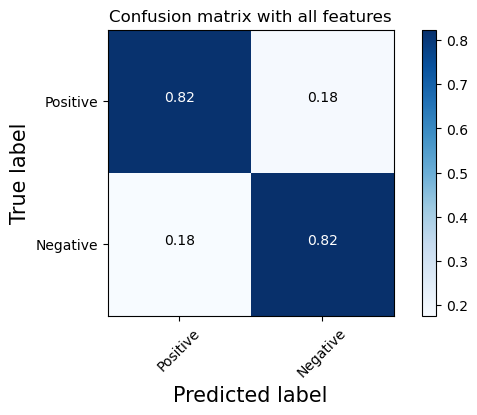

In [198]:
# Print accuracy:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
    
# compute the confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
# plot cnf_matrix
plt.figure(figsize=(6,4))
plot_confusion_matrix(cnf_matrix, classes=['Positive','Negative'],normalize=True,
                      title='Confusion matrix with all features')

Here we can see the same general accuracy score of 82% meaning that 82% of all samples in the test set were classified correctly. However the confusion matrix help having a more visual understanding of the predicted classes. We can see that 82% of the predictions are True Positive or True Negative

The dataset consists of 1500 positive, and 1500 negative, it's a binary distribution where the data set is totally balance. That's confusion matrix show that the model respect the dataset parameter by classifying the exact same number of words in each categories. However that's perfectly balance result is a bit suspicious and I would like to have your explanation on this result

Maybe thats strange score is due a a diffculty I went trough during the feating part. Weirdly the X_train has missing values. I replace them by 0 so maybe the model is actually overfitting the data set. 